In [1]:
%matplotlib inline

In [2]:
import torch.nn as nn                                                                      
from torchvision import models
# lets name oue neural network "CNN"
class CNN(nn.Module):
    
    # this is our CNN initilization function     
    def __init__(self, size, num_classes):
        super(CNN, self).__init__()
        self.extract = nn.Sequential( # lets make a 2D convolution layer
                                      nn.Conv2d( in_channels = size, out_channels = 10, 
                                                 kernel_size = 9, stride = 1, padding = 1), 
                                      nn.ReLU(inplace = True),
                                      nn.MaxPool2d(2),                                                                
                                      nn.Dropout(0.1),
                                      # ----------------------------------------------------------- 
                                      # now, lets make another layer of convolution, pooling, and drop out
                                      #nn.Conv2d( in_channels = 2, out_channels = 4, 
                                                 #kernel_size = 3, stride = 1, padding = 1),
                                                 # in_channels here needs to match out_channels above
                                                 # lets use 5 filters 
                                      #nn.ReLU(inplace = True),
                                      #nn.MaxPool2d(2),
                                      #nn.Dropout(0.1), 
                                    )

        # ok, now we are going to make a simple MLP classifier on the end of our above features
        self.decimate = nn.Sequential( nn.Linear(10*(11*11), 12),  
                                            # take our 10 filters whose response fields are 11x11 to 12 neurons
                                       nn.ReLU(inplace = True), # run a nonlinearity
                                       nn.Dropout(0.2), # some drop out
                                       nn.Linear(12, num_classes) ) # map the 32 down to our number of output classes
 
    #----------------------------
    # Model: Invoke Forward Pass
    #----------------------------

    def forward(self, x):

        features = self.extract(x) # easy, pass input (x) to our "feature extraction" above
        features = features.view(features.size()[0], -1) # now, flatten 7x7x4 matrix to 1D array of 7*7*4 size
        myresult = self.decimate(features) # pass that to our MLP classifier, and done!!!

        return myresult

Next, lets load our training data set for MNIST

[num of images, image x size, image y size]
torch.Size([60000, 28, 28])
what type of data is it?
<class 'torch.Tensor'>
what is min and max values?
tensor(255, dtype=torch.uint8)
tensor(0, dtype=torch.uint8)


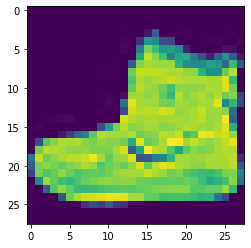

In [3]:
import os
import torch
import numpy as np
from torchvision import datasets
import torchvision

# nice built in functions for common data sets 
#  go read https://pytorch.org/docs/stable/torchvision/datasets.html
train = datasets.FashionMNIST( root = './', # where to download data set to
                       train = True, # If True, creates dataset from training.pt, otherwise from test.pt
                       transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor()]), # convert data into tensor vs PIL image 
                       download = True)

print("[num of images, image x size, image y size]")
print(train.data.shape)

print("what type of data is it?")
print(type(train.data[0]))

print("what is min and max values?")
print(torch.max(train.data[0]))
print(torch.min(train.data[0]))

# lets plot it
import matplotlib.pyplot as plt
plt.imshow(train.data[0])

If you want to work with validation or test data, follow

    valid = datasets.MNIST( root = './', train = False, download = True)
    test = datasets.MNIST( root = './', train = False, download = True)

Lets now make a data loader object to hold onto our data that we can use for batch processing and stuff

In [4]:
import torch.utils.data as tech 

# how big of batches do you guys/gals want?
batch_size = 16

# our data loader that we will use to manage our data
train_ld = tech.DataLoader(dataset = train, shuffle = True, batch_size = batch_size)       

Again, you can work with validation and test data as well
    
    valid = tech.DataLoader(dataset = valid, shuffle = False, batch_size = batch_size)      
    test = tech.DataLoader(dataset = test, shuffle = False, batch_size = 1) 

Lets create an instance of our CNN

In [5]:
input_size = 1 # just 1 band for MNIST
num_classes = 10 # we have 10 classes in MNIST
model = CNN(input_size, num_classes) 

Now, pick optimization algorithm and error function

In [6]:
learning_rate = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
costfx = torch.nn.CrossEntropyLoss()

Training time!

In [7]:
from tqdm import tqdm_notebook as tqdm

num_epochs = 1                                        
for epoch in range(num_epochs): # how many epochs? 
    
    epoch_loss = [] # keep track of our loss?
    
    for batch_id, train_params in enumerate(tqdm(train_ld)):  # lets grab a bunch of mini-batches from our training data set
        
        # samples are our images, labels are their class labels
        samples, labels = train_params
        
        # we need to convert these into tensors
        samples = samples.type('torch.FloatTensor') 
        labels = labels.type('torch.LongTensor')  

        # lets predict (forward pass)
        prediction = model(samples)
        # evaluate our error
        loss = costfx(prediction, labels)
        # keep track of that loss
        epoch_loss.append(loss.item())
        # zero our gradients
        optimizer.zero_grad()  
        # calc our gradients
        loss.backward()     
        # do our update
        optimizer.step()
    
    # keep track of loss over our batches
    epoch_loss = sum(epoch_loss)/len(epoch_loss)  

Save the model

In [8]:
torch.save(model, './my_mnist_model.pt') 

C:\Users\13122\Anaconda3\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type CNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Render the filters

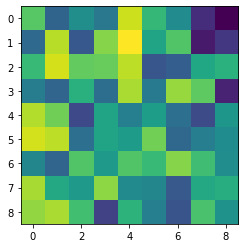

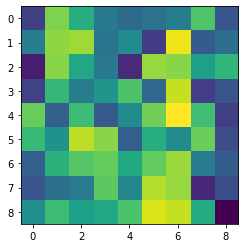

In [9]:
for i in range(2):
    plt.figure()
    plt.imshow( np.squeeze( model.extract[0].weight[i,:,:,:].detach().numpy() ) )

Next, lets scrub all the junk in our net that was needed at training time, like dropout

In [10]:
model = model.eval()

Lets do resub, load back up a data point and see how we did ...

In [11]:
%matplotlib inline
from tqdm import tqdm_notebook as tqdm

# resub because we are loading our MNIST training data set
test = tech.DataLoader(dataset = train, shuffle = False, batch_size = 1) 

# how did we do...
ConfusionMatrix = torch.zeros((10,10))
for sample, label in tqdm(test):
    # what is its label?
    label = int(label.numpy())
    #print("Real label is")
    #print(label)
    # convert the sample (image) to a tensor for PyTorch
    sample = sample.type('torch.FloatTensor')
    # do forward pass (i.e., prediction)
    prediction = model(sample) 
    # take the largest output and return integer of which it was (make a classification decision)
    prediction = int(torch.argmax(prediction).numpy())
    # what was our prediction?
    #print(prediction)
    ConfusionMatrix[label,prediction] = ConfusionMatrix[label,prediction] + 1

Lets plot a confusion matrix (see https://seaborn.pydata.org/generated/seaborn.heatmap.html)

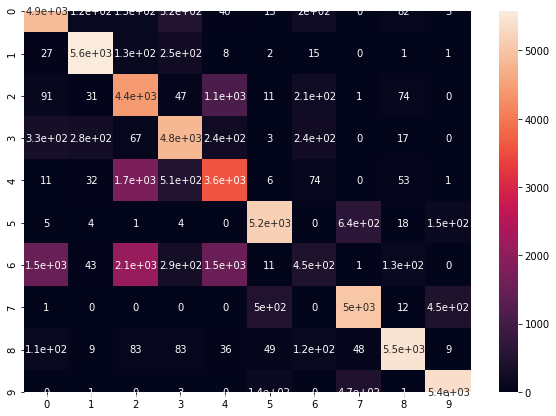

In [18]:
import seaborn as sn  # yes, I had to "conda install seaborn"
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(np.asarray(ConfusionMatrix), index = [i for i in "0123456789"],
                  columns = [i for i in "0123456789"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)
plt.show()

Lets do it on the test data (not seen before)

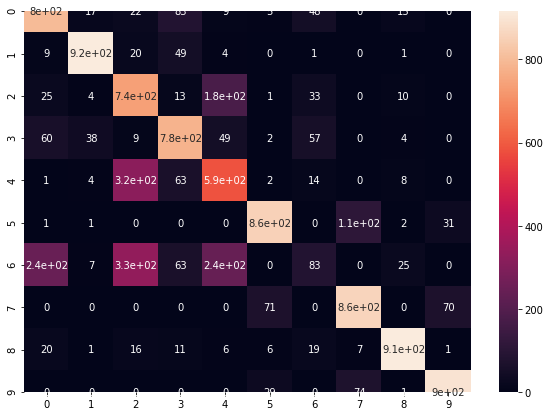

In [19]:
test = datasets.FashionMNIST( root = './', 
                       train = False, 
                       transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor()]), # convert data into tensor vs PIL image                       
                       download = True)

# resub because we are loading our MNIST training data set
test2 = tech.DataLoader(dataset = test, shuffle = False, batch_size = 1) 

# how did we do...
ConfusionMatrix = torch.zeros((10,10))
for sample, label in tqdm(test2):
    # what is its label?
    label = int(label.numpy())
    #print("Real label is")
    #print(label)
    # convert the sample (image) to a tensor for PyTorch
    sample = sample.type('torch.FloatTensor')
    # do forward pass (i.e., prediction)
    prediction = model(sample) 
    # take the largest output and return integer of which it was (make a classification decision)
    prediction = int(torch.argmax(prediction).numpy())
    # what was our prediction?
    #print(prediction)
    ConfusionMatrix[label,prediction] = ConfusionMatrix[label,prediction] + 1
    
df_cm = pd.DataFrame(np.asarray(ConfusionMatrix), index = [i for i in "0123456789"],
                  columns = [i for i in "0123456789"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)
plt.show()